In [56]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import dame_flame

dtype_map = {
    'NCESDistrictID': 'string',
    'NCESSchoolID': 'string',
    'StateAssignedDistID': 'string',
    'Flag_AssmtNameChange': 'string',
    'Flag_CutScoreChange_ELA': 'string',
    'Flag_CutScoreChange_math': 'string',
    'Flag_CutScoreChange_sci': 'string',
    'Flag_CutScoreChange_soc': 'string',
    'DistType': 'string',
    'DistCharter': 'string',
    'DistLocale': 'string',
    'SchType': 'string',
    'SchLevel': 'string',
    'SchVirtual': 'string',
}

df = pd.read_csv("data/merged_df_clean.csv", dtype=dtype_map, low_memory=False)


# Step 2: Ensure numeric columns are properly parsed
numeric_cols = [
    'Per Pupil Expenditure', 'AvgScaleScore', 'Year_final',
    'StudentGroup_TotalTested', 'StudentSubGroup_TotalTested',
    'Lev1_percent', 'Lev2_percent', 'Lev3_percent', 'Lev4_percent', 'Lev5_percent',
    'Lev1_count', 'Lev2_count', 'Lev3_count', 'Lev4_count', 'Lev5_count',
    'ProficientOrAbove_percent', 'ProficientOrAbove_count', 'ParticipationRate',
    'Grade_numeric',"Total Revenue (TOTALREV) per Pupil (V33)",
    "American Indian/Alaska Native - female", "American Indian/Alaska Native - male",
    "Asian or Asian/Pacific Islander - female", "Asian or Asian/Pacific Islander - male",
    "Black or African American - female", "Black or African American - male",
    "Hispanic - female", "Hispanic - male",
    "Nat. Hawaiian or Other Pacific Isl. - female", "Nat. Hawaiian or Other Pacific Isl. - male",
    "Two or More Races - female", "Two or More Races - male",
    "White - female", "White - male"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 3: Clean and standardize string/categorical columns
str_cols = ['State', 'Subject', 'GradeLevel',
            'StudentGroup', 'DistName', 'SchName']
for col in str_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

df['Year_clean'] = df['SchYear_clean']

df["Year_clean"] = pd.to_numeric(df["Year_clean"], errors="coerce")
#df = df[df["Year_clean"] < 2019]
cpi_index = {
    2010: 218.056,
    2011: 224.939,
    2012: 229.594,
    2013: 232.957,
    2014: 236.736,
    2015: 237.017,
    2016: 240.007,
    2017: 245.120,
    2018: 251.107,
    2019: 255.657,
    2020: 258.811,
    2021: 270.970,
    2022: 292.655,
    2023: 304.702
}

# Map CPI factor for each row
df["cpi_factor"] = df["Year_clean"].map(lambda y: cpi_index.get(y, np.nan))

# Convert to 2020 dollars
df["Per Pupil Expenditure (adj)"] = (
    df["Per Pupil Expenditure"] / df["cpi_factor"] * cpi_index[2020]
)

# If you have a total revenue column, adjust that too
df["Per Pupil Revenue (adj)"] = (
    df["Total Revenue (TOTALREV) per Pupil (V33)"] / df["cpi_factor"] * cpi_index[2020]
    )

In [57]:
df.columns

Index(['State', 'StateAbbrev', 'StateFips', 'SchYear', 'DataLevel', 'DistName',
       'SchName', 'NCESDistrictID', 'StateAssignedDistID', 'NCESSchoolID',
       'StateAssignedSchID', 'AssmtName', 'AssmtType', 'Subject', 'GradeLevel',
       'StudentGroup', 'StudentGroup_TotalTested', 'StudentSubGroup',
       'StudentSubGroup_TotalTested', 'Lev1_count', 'Lev1_percent',
       'Lev2_count', 'Lev2_percent', 'Lev3_count', 'Lev3_percent',
       'Lev4_count', 'Lev4_percent', 'Lev5_count', 'Lev5_percent',
       'AvgScaleScore', 'ProficiencyCriteria', 'ProficientOrAbove_count',
       'ProficientOrAbove_percent', 'ParticipationRate',
       'Flag_AssmtNameChange', 'Flag_CutScoreChange_ELA',
       'Flag_CutScoreChange_math', 'Flag_CutScoreChange_sci',
       'Flag_CutScoreChange_soc', 'DistType', 'DistCharter', 'DistLocale',
       'SchType', 'SchLevel', 'SchVirtual', 'CountyName', 'CountyCode',
       'DistrictName_clean', 'SchYear_clean', 'Agency Name',
       'Agency ID - NCES Assigned 

In [58]:
df["Total_Students"] = df[[
    "American Indian/Alaska Native - female", "American Indian/Alaska Native - male",
    "Asian or Asian/Pacific Islander - female", "Asian or Asian/Pacific Islander - male",
    "Black or African American - female", "Black or African American - male",
    "Hispanic - female", "Hispanic - male",
    "Nat. Hawaiian or Other Pacific Isl. - female", "Nat. Hawaiian or Other Pacific Isl. - male",
    "Two or More Races - female", "Two or More Races - male",
    "White - female", "White - male"
]].sum(axis=1)
df["pct_black"] = (df["Black or African American - female"] + df["Black or African American - male"]) / df["Total_Students"]
df["pct_white"] = (df["White - female"] + df["White - male"]) / df["Total_Students"]
df["pct_hispanic"] = (df["Hispanic - female"] + df["Hispanic - male"]) / df["Total_Students"]
df["pct_asian"] = (df["Asian or Asian/Pacific Islander - female"] + df["Asian or Asian/Pacific Islander - male"]) / df["Total_Students"]
df["pct_native"] = (df["American Indian/Alaska Native - female"] + df["American Indian/Alaska Native - male"]) / df["Total_Students"]
df["pct_multiracial"] = (df["Two or More Races - female"] + df["Two or More Races - male"]) / df["Total_Students"]
df["pct_pacific"] = (df["Nat. Hawaiian or Other Pacific Isl. - female"] + df["Nat. Hawaiian or Other Pacific Isl. - male"]) / df["Total_Students"]
df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [59]:
# : bin into 4 quantiles
race_props = ['pct_black', 'pct_white', 'pct_hispanic', 'pct_asian', 'pct_native', 'pct_multiracial', 'pct_pacific']
for col in race_props:
    if df[col].notna().sum() > 0:
        df[f"{col}_bin"] = pd.qcut(df[col], q=4, duplicates="drop").astype(str)

In [60]:
# # Filter non-null rows
# filtered_df = df[["DistrictName_clean", "Grade_numeric", "Year_clean", 
#                   "Per Pupil Revenue (adj, lag1)", "Per Pupil Revenue (adj)"]].dropna()

# # Sort and group
# grouped = filtered_df.sort_values(["DistrictName_clean", "Grade_numeric", "Year_clean"])

# # Compute differences
# grouped["Revenue_diff"] = grouped.groupby(
#     ["DistrictName_clean", "Grade_numeric"]
# )["Per Pupil Revenue (adj)"].diff()

# grouped["Revenue_lag1_diff"] = grouped.groupby(
#     ["DistrictName_clean", "Grade_numeric"]
# )["Per Pupil Revenue (adj, lag1)"].diff()

# # Show only the requested columns
# print(grouped[["DistrictName_clean", "Grade_numeric", "Year_clean", "Revenue_diff", "Revenue_lag1_diff"]])


In [61]:
# Sort by district and year
df1 = df.sort_values(["DistrictName_clean", "Year_clean"])

# Compute lagged revenue and lagged year
df1["Per Pupil Revenue (adj, lag1)"] = df1.groupby("DistrictName_clean")["Per Pupil Revenue (adj)"].shift(1)
df1["Year_lag1"] = df1.groupby("DistrictName_clean")["Year_clean"].shift(1)

# Keep only rows where the lag year is exactly one less
df_lagged = df1[df1["Year_clean"] - df1["Year_lag1"] == 1].copy()
# df_lagged = df[
#      df["Per Pupil Revenue (adj, lag1)"].notna() &
#      df["ProficientOrAbove_percent"].notna()
# # ].copy()

In [62]:
# # Filter non-null rows
# filtered_df = df[["DistrictName_clean", "Grade_numeric", "Year_clean", 
#                   "Per Pupil Revenue (adj, lag1)", "Per Pupil Revenue (adj)"]].dropna()

# # Group and sort
# grouped = filtered_df.sort_values(["DistrictName_clean", "Grade_numeric", "Year_clean"])

# # Display or inspect
# print(grouped)
# print(grouped[["DistrictName_clean", "Grade_numeric", "Year_clean", "Per Pupil Revenue (adj, lag1)", "Per Pupil Revenue (adj)"]])



In [63]:
# df = df[
#     (df["Per Pupil Expenditure (adj)"] <= 15000) &
#     (df["Per Pupil Revenue (adj)"] <= 15000) &
#     (df["Per Pupil Revenue (adj)"] > 0)
# ]
# Columns to check
match_vars = [
    'Grade_numeric', 'Year_clean', 'State', 'DistLocale',
    'DistCharter', 'DistType', 'Subject',
    'pct_black', 'pct_white', 'pct_hispanic', 'pct_asian',
    'pct_native', 'pct_multiracial', 'pct_pacific'
]
# Count rows where all these columns are non-null
non_null_count = df[match_vars].dropna().shape[0]
non_null_count

10976

In [64]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

def prepare_matching_data(
    df,
    outcome_col="ProficientOrAbove_percent",
    treatment_col="Per Pupil Revenue (adj)",
    threshold_quantile=0.5,
    match_vars=None
):
    if match_vars is None:
        # match_vars = [
        #     'Grade_numeric',
        #     'Year_clean',
        #     'State',
        #     'DistLocale',
        #     'DistCharter',
        #     'DistType',
        #     'Subject'
        # ]
        match_vars = [
            'Grade_numeric', 'Year_clean', 'State', 'DistLocale',
            'DistCharter', 'DistType', 'Subject',
            'pct_black_bin', 'pct_white_bin', 'pct_hispanic_bin', 'pct_asian_bin',
            'pct_native_bin', 'pct_multiracial_bin', 'pct_pacific_bin'
        ]


    # Step 1: Filter rows with non-null treatment & outcome
    reg_df = df[
        df[outcome_col].notna() & df[treatment_col].notna()
    ].copy()

    # Step 2: Define treatment based on threshold
    threshold = reg_df[treatment_col].quantile(threshold_quantile)
    reg_df["treatment"] = (reg_df[treatment_col] >= threshold).astype(int)

    # Step 3: Subset relevant columns
    subset_cols = ["treatment", outcome_col] + match_vars
    subset_df = reg_df[subset_cols].dropna().copy()

    # Step 4: Rename outcome column
    subset_df = subset_df.rename(columns={outcome_col: "outcome"})

    # Step 5: Encode categorical variables
    category_encoders = {}
    for col in match_vars:
        cat_col = subset_df[col].astype("category")
        subset_df[col] = cat_col.cat.codes
        category_encoders[col] = cat_col.cat.categories

    subset_df = subset_df.reset_index(drop=True)

    return subset_df, category_encoders, threshold


In [65]:
matching1, enc1, thresh1 = prepare_matching_data(
    df,
    outcome_col="AvgScaleScore",
    treatment_col="Per Pupil Expenditure (adj)"
)

matching2, enc2, thresh2 = prepare_matching_data(
    df,
    outcome_col="ProficientOrAbove_percent",
    treatment_col="Per Pupil Expenditure (adj)"
)

matching3, enc3, thresh3 = prepare_matching_data(
    df,
    outcome_col="ProficientOrAbove_percent",
    treatment_col="Per Pupil Revenue (adj)"
)

matching4, enc4, thresh4 = prepare_matching_data(
    df,
    outcome_col="AvgScaleScore",
    treatment_col="Per Pupil Revenue (adj)"
)


In [66]:
import matplotlib.pyplot as plt
from dame_flame import matching

def run_dame_matching(matching_df, early_stop_iterations=float('inf'), verbose=3):
    model = matching.DAME(
        repeats=False,
        verbose=verbose,
        want_pe=True,
        early_stop_iterations=early_stop_iterations,
        stop_unmatched_t=True,
        early_stop_un_c_frac=0.2,         # Stop when ≤80% of treated are matched
    )
    model.fit(
        matching_df,
        treatment_column_name="treatment",
        outcome_column_name="outcome"
    )
    results = model.predict(matching_df)

    # Plot PE over iterations
    pe_values = model.pe_each_iter
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(pe_values)), pe_values, marker='o')
    plt.title("DAME Matching - Predictive Error by Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Predictive Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, results



🔧 Running match: outcome=AvgScaleScore, treatment=Per Pupil Expenditure (adj)
Completed iteration 0 of matching
	Number of matched groups formed in total:  24
	Unmatched treated units:  1066 out of a total of  1090 treated units
	Unmatched control units:  1044 out of a total of  1068 control units
	Number of matches made this iteration:  48
	Number of matches made so far:  48
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  52.08338935350736
Completed iteration 1 of matching
	Number of matched groups formed in total:  24
	Unmatched treated units:  1066 out of a total of  1090 treated units
	Unmatched control units:  1044 out of a total of  1068 control units
	Number of matches made this iteration:  0
	Number of matches made so far:  48
	Covariates dropped so far:  frozenset({'DistType'})
	Predictive error of covariate set used to match:  52.08338935350735
48 units matched. We stopped after iteration 1


/tmp/ipykernel_2250/3187813902.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


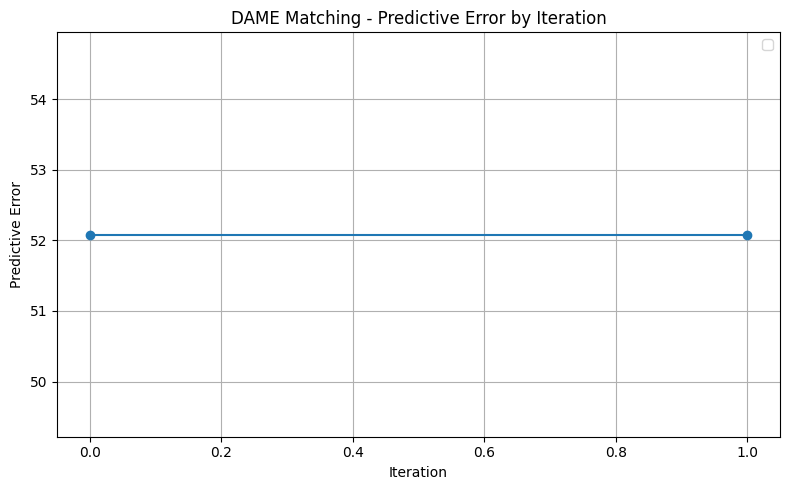


🔧 Running match: outcome=ProficientOrAbove_percent, treatment=Per Pupil Expenditure (adj)
Completed iteration 0 of matching
	Number of matched groups formed in total:  106
	Unmatched treated units:  5823 out of a total of  5945 treated units
	Unmatched control units:  5823 out of a total of  5941 control units
	Number of matches made this iteration:  240
	Number of matches made so far:  240
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.038604930791541765
Completed iteration 1 of matching
	Number of matched groups formed in total:  106
	Unmatched treated units:  5823 out of a total of  5945 treated units
	Unmatched control units:  5823 out of a total of  5941 control units
	Number of matches made this iteration:  0
	Number of matches made so far:  240
	Covariates dropped so far:  frozenset({'pct_pacific_bin'})
	Predictive error of covariate set used to match:  0.03861396981571372
240 units matched. We stopped after iteration 1


/tmp/ipykernel_2250/3187813902.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


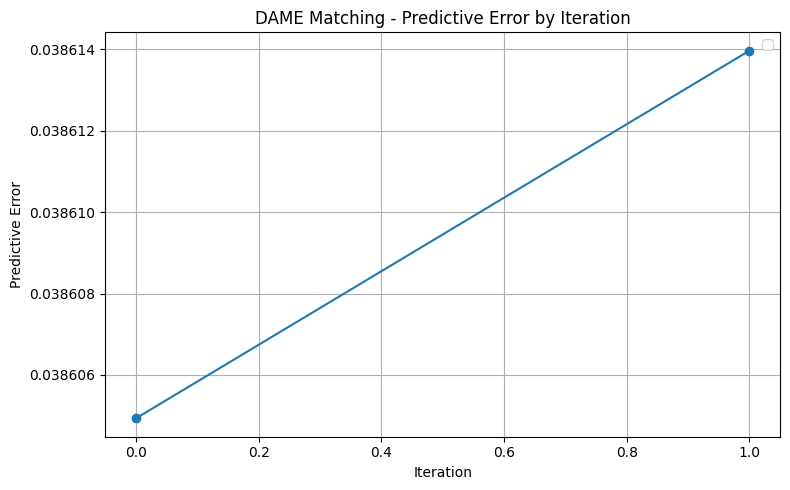


🔧 Running match: outcome=ProficientOrAbove_percent, treatment=Per Pupil Revenue (adj, lag1)
Completed iteration 0 of matching
	Number of matched groups formed in total:  4
	Unmatched treated units:  411 out of a total of  416 treated units
	Unmatched control units:  411 out of a total of  415 control units
	Number of matches made this iteration:  9
	Number of matches made so far:  9
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.034523124774965955
Completed iteration 1 of matching
	Number of matched groups formed in total:  4
	Unmatched treated units:  411 out of a total of  416 treated units
	Unmatched control units:  411 out of a total of  415 control units
	Number of matches made this iteration:  0
	Number of matches made so far:  9
	Covariates dropped so far:  frozenset({'Subject'})
	Predictive error of covariate set used to match:  0.034523124774965955
9 units matched. We stopped after iteration 1


/tmp/ipykernel_2250/3187813902.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


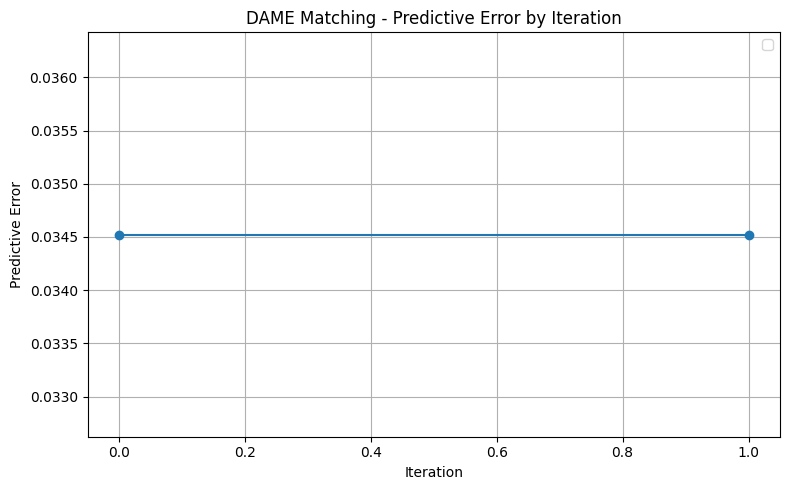


🔧 Running match: outcome=AvgScaleScore, treatment=Per Pupil Revenue (adj, lag1)
Completed iteration 0 of matching
	Number of matched groups formed in total:  2
	Unmatched treated units:  90 out of a total of  92 treated units
	Unmatched control units:  89 out of a total of  91 control units
	Number of matches made this iteration:  4
	Number of matches made so far:  4
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1421.3893145875475


/tmp/ipykernel_2250/3187813902.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Completed iteration 1 of matching
	Number of matched groups formed in total:  2
	Unmatched treated units:  90 out of a total of  92 treated units
	Unmatched control units:  89 out of a total of  91 control units
	Number of matches made this iteration:  0
	Number of matches made so far:  4
	Covariates dropped so far:  frozenset({'Grade_numeric'})
	Predictive error of covariate set used to match:  1421.3893145875472
4 units matched. We stopped after iteration 1


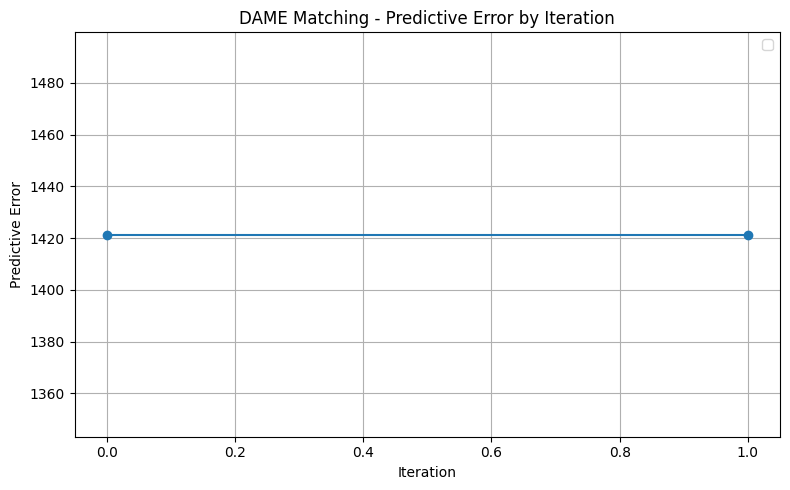

In [ ]:
combinations = [
    ("AvgScaleScore", "Per Pupil Expenditure (adj)",df),
    ("ProficientOrAbove_percent", "Per Pupil Expenditure (adj)",df),
    ("ProficientOrAbove_percent", "Per Pupil Revenue (adj, lag1)",df_lagged),
    ("AvgScaleScore", "Per Pupil Revenue (adj, lag1)",df_lagged),
]

models = {}

for outcome_col, treatment_col,df1 in combinations:
    print(f"\n🔧 Running match: outcome={outcome_col}, treatment={treatment_col}")
    matching_df, encoders, threshold = prepare_matching_data(df1, outcome_col, treatment_col)
    model, results = run_dame_matching(matching_df, early_stop_iterations=1000)
    models[(outcome_col, treatment_col)] = (model, results)

In [68]:
# combinations = [
#     ("AvgScaleScore", "Per Pupil Expenditure (adj)", 7),
#     ("ProficientOrAbove_percent", "Per Pupil Expenditure (adj)", 11),
#     ("ProficientOrAbove_percent", "Per Pupil Revenue (adj)", 7),
#     ("AvgScaleScore", "Per Pupil Revenue (adj)", 15)
# ]
# models = {}

# for outcome_col, treatment_col, early_stop in combinations:
#     print(f"\n🔧 Running match: outcome={outcome_col}, treatment={treatment_col}, stop={early_stop}")
#     matching_df, encoders, threshold = prepare_matching_data(df, outcome_col, treatment_col)
#     model, results = run_dame_matching(matching_df, early_stop_iterations=early_stop)
#     models[(outcome_col, treatment_col)] = (model, results)


In [69]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    # Recalculate control weights
    control_df = better.loc[better[t] == 0].copy()

    print("📦 Num control observations used:", num_control_obs)
    # print("🧮 Sum of assigned weights:", control_df["weights"].sum())
    # print("❓ Any NaN weights?", control_df["weights"].isna().sum())
    # print("🧯 Any infinite weights?", np.isinf(control_df["weights"]).sum())

    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert np.isclose(control_df["weights"].sum(), num_control_obs, rtol=1e-4)


    return better


In [70]:
matched_dfs = {}
for key, (model, results) in models.items():
    print(f"\n📄 Extracting matched DataFrame for: {key}")
    df2 = get_dataframe(model, results)
    matched_dfs[key] = df2


📄 Extracting matched DataFrame for: ('AvgScaleScore', 'Per Pupil Expenditure (adj)')
📦 Num control observations used: 24

📄 Extracting matched DataFrame for: ('ProficientOrAbove_percent', 'Per Pupil Expenditure (adj)')
📦 Num control observations used: 118

📄 Extracting matched DataFrame for: ('ProficientOrAbove_percent', 'Per Pupil Revenue (adj, lag1)')
📦 Num control observations used: 4

📄 Extracting matched DataFrame for: ('AvgScaleScore', 'Per Pupil Revenue (adj, lag1)')
📦 Num control observations used: 2


In [71]:
for key, df1 in matched_dfs.items():
    if "State" in df1.columns:
        print(f"{key}:")
        state_counts = df1["State"].value_counts().sort_index()
        for state, count in state_counts.items():
            print(f"  State {state}: {count} matched observations")
    else:
        print(f"{key}: 'state' column not found")


('AvgScaleScore', 'Per Pupil Expenditure (adj)'):
  State 0: 48 matched observations
('ProficientOrAbove_percent', 'Per Pupil Expenditure (adj)'):
  State 1: 24 matched observations
  State 3: 216 matched observations
('ProficientOrAbove_percent', 'Per Pupil Revenue (adj, lag1)'):
  State 3: 9 matched observations
('AvgScaleScore', 'Per Pupil Revenue (adj, lag1)'):
  State 0: 4 matched observations


Arizona', 'Florida', 'Hawaii', 'Indiana'

In [72]:
for key in matched_dfs:
    df3 = matched_dfs[key]
    if "State" in df3.columns:
        matched_dfs[key] = df3[df3["State"] != 2].copy()

In [73]:
example_key = ("AvgScaleScore", "Per Pupil Revenue (adj, lag1)")
matched_dfs[example_key].head()

,treatment,outcome,Grade_numeric,Year_clean,State,DistLocale,DistCharter,DistType,Subject,pct_black_bin,pct_white_bin,pct_hispanic_bin,pct_asian_bin,pct_native_bin,pct_multiracial_bin,pct_pacific_bin,match_group,match_group_size,weights
29,1,202.1,0,5,0,5,0,1,0,1,1,3,3,2,3,2,0.0,2.0,1.0
59,0,203.4,0,5,0,5,0,1,0,1,1,3,3,2,3,2,0.0,2.0,1.0
154,0,304.0,0,1,0,6,0,1,0,1,1,3,3,2,2,1,1.0,2.0,1.0
178,1,302.0,0,1,0,6,0,1,0,1,1,3,3,2,2,1,1.0,2.0,1.0


In [74]:
import statsmodels.formula.api as smf

def run_naive_regression(matching_df):
    """Runs WLS regression without matching (naive model)."""
    model = smf.wls(
        formula="outcome ~ treatment", 
        data=matching_df.dropna(subset=["outcome"])
    ).fit()

    print("📉 Raw (unmatched) regression:")
    print(model.summary())
    return model


In [75]:
def run_matched_regression(matched_df):
    """Runs WLS regression on matched data with weights."""
    model = smf.wls(
        formula="outcome ~ treatment", 
        data=matched_df, 
        weights=matched_df["weights"]
    ).fit()

    print("📈 Weighted (matched) regression:")
    print(model.summary())
    return model


In [76]:
# Get matched dataframes and run weighted regression for each combo
for combo in models:
    print(f"\n📈 Matched regression for outcome={combo[0]}, treatment={combo[1]}")
    matched_df = get_dataframe(*models[combo])
    run_matched_regression(matched_df)



📈 Matched regression for outcome=AvgScaleScore, treatment=Per Pupil Expenditure (adj)
📦 Num control observations used: 24
📈 Weighted (matched) regression:
                            WLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.012
Model:                            WLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.5810
Date:                Wed, 30 Apr 2025   Prob (F-statistic):              0.450
Time:                        05:31:40   Log-Likelihood:                -184.53
No. Observations:                  48   AIC:                             373.1
Df Residuals:                      46   BIC:                             376.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|

/home/vscode/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [77]:
df["FundingQuantile"] = pd.qcut(df["Per Pupil Expenditure (adj)"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

model = smf.ols("AvgScaleScore ~ C(FundingQuantile)", data=df.dropna(subset=["AvgScaleScore", "FundingQuantile"])).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          AvgScaleScore   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     10.03
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           1.45e-06
Time:                        05:31:40   Log-Likelihood:                -8409.0
No. Observations:                2158   AIC:                         1.683e+04
Df Residuals:                    2154   BIC:                         1.685e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

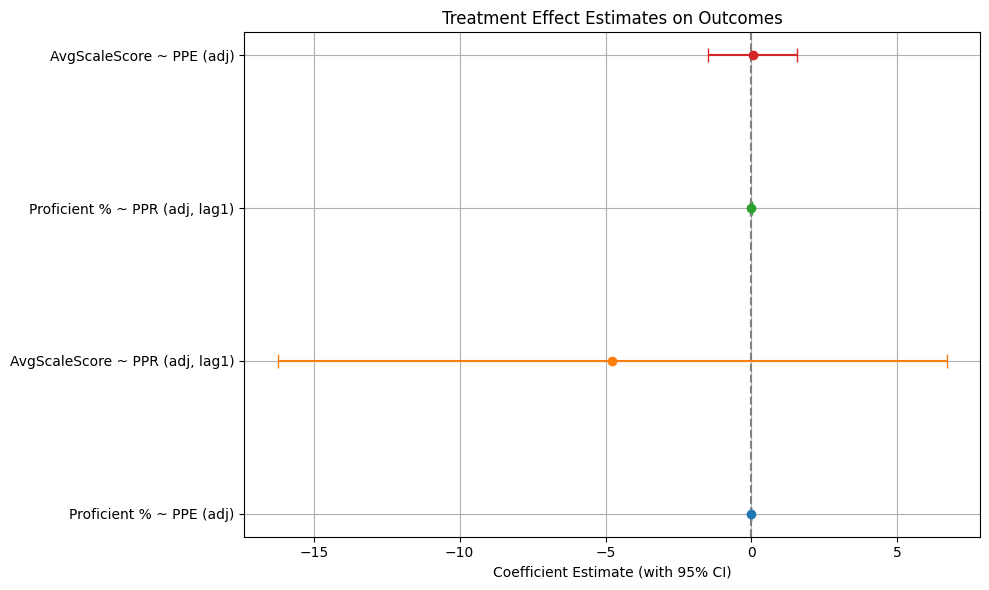

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a summary table of the regression results
summary_data = [
    {
        "Outcome": "AvgScaleScore",
        "Treatment": "PPE (adj)",
        "Coefficient": 0.0418,
        "StdErr": 0.776,
        "PValue": 0.957,
        "R2": 0.000
    },
    {
        "Outcome": "Proficient %",
        "Treatment": "PPE (adj)",
        "Coefficient": -0.0169,
        "StdErr": 0.004,
        "PValue": 0.0000328,
        "R2": 0.002
    },
    {
        "Outcome": "Proficient %",
        "Treatment": "PPR (adj, lag1)",
        "Coefficient": -0.0117,
        "StdErr": 0.016,
        "PValue": 0.471,
        "R2": 0.001
    },
    {
        "Outcome": "AvgScaleScore",
        "Treatment": "PPR (adj, lag1)",
        "Coefficient": -4.7724,
        "StdErr": 5.847,
        "PValue": 0.416,
        "R2": 0.006
    }
]

summary_df = pd.DataFrame(summary_data)

# Add confidence intervals
summary_df["CI Lower"] = summary_df["Coefficient"] - 1.96 * summary_df["StdErr"]
summary_df["CI Upper"] = summary_df["Coefficient"] + 1.96 * summary_df["StdErr"]

# Sort by p-value ascending
summary_df_sorted = summary_df.sort_values("PValue")

# Plotting
plt.figure(figsize=(10, 6))
for idx, row in summary_df_sorted.iterrows():
    label = f"{row['Outcome']} ~ {row['Treatment']}"
    plt.errorbar(
        row["Coefficient"], 
        label, 
        xerr=1.96 * row["StdErr"], 
        fmt='o', 
        capsize=5
    )
plt.axvline(x=0, color='grey', linestyle='--')
plt.xlabel("Coefficient Estimate (with 95% CI)")
plt.title("Treatment Effect Estimates on Outcomes")
plt.grid(True)
plt.tight_layout()

plt.show()


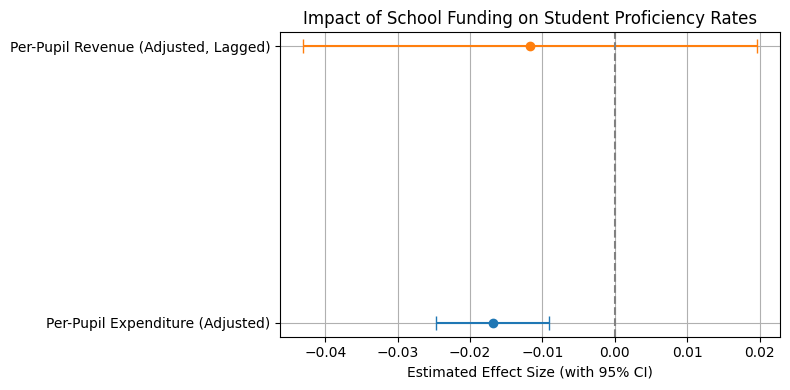

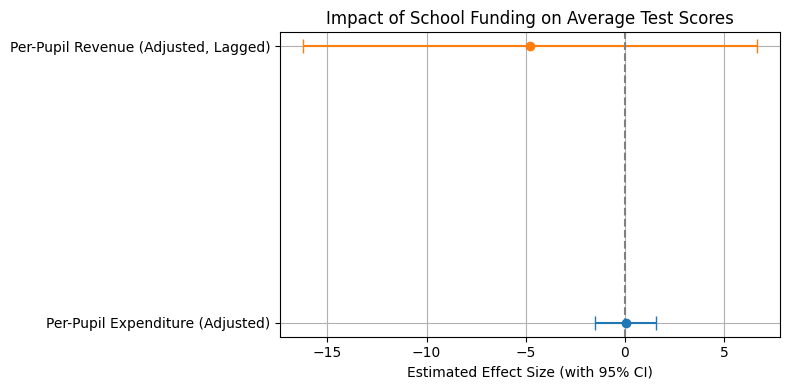

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the summary table again
summary_data = [
    {
        "Outcome": "AvgScaleScore",
        "Treatment": "PPE (adj)",
        "Coefficient": 0.0418,
        "StdErr": 0.776,
        "PValue": 0.957,
        "R2": 0.000
    },
    {
        "Outcome": "Proficient %",
        "Treatment": "PPE (adj)",
        "Coefficient": -0.0169,
        "StdErr": 0.004,
        "PValue": 0.0000328,
        "R2": 0.002
    },
    {
        "Outcome": "Proficient %",
        "Treatment": "PPR (adj, lag1)",
        "Coefficient": -0.0117,
        "StdErr": 0.016,
        "PValue": 0.471,
        "R2": 0.001
    },
    {
        "Outcome": "AvgScaleScore",
        "Treatment": "PPR (adj, lag1)",
        "Coefficient": -4.7724,
        "StdErr": 5.847,
        "PValue": 0.416,
        "R2": 0.006
    }
]

summary_df = pd.DataFrame(summary_data)
summary_df["CI Lower"] = summary_df["Coefficient"] - 1.96 * summary_df["StdErr"]
summary_df["CI Upper"] = summary_df["Coefficient"] + 1.96 * summary_df["StdErr"]

# Plot: Proficient %

# Rename treatments for clarity
label_map = {
    "PPE (adj)": "Per-Pupil Expenditure (Adjusted)",
    "PPR (adj, lag1)": "Per-Pupil Revenue (Adjusted, Lagged)"
}

# Plot: Proficient %
plt.figure(figsize=(8, 4))
proficient_df = summary_df[summary_df["Outcome"] == "Proficient %"]
for idx, row in proficient_df.iterrows():
    label = label_map.get(row["Treatment"], row["Treatment"])
    plt.errorbar(
        row["Coefficient"],
        label,
        xerr=1.96 * row["StdErr"],
        fmt='o',
        capsize=5
    )
plt.axvline(x=0, color='grey', linestyle='--')
plt.xlabel("Estimated Effect Size (with 95% CI)")
plt.title("Impact of School Funding on Student Proficiency Rates")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: AvgScaleScore
plt.figure(figsize=(8, 4))
score_df = summary_df[summary_df["Outcome"] == "AvgScaleScore"]
for idx, row in score_df.iterrows():
    label = label_map.get(row["Treatment"], row["Treatment"])
    plt.errorbar(
        row["Coefficient"],
        label,
        xerr=1.96 * row["StdErr"],
        fmt='o',
        capsize=5
    )
plt.axvline(x=0, color='grey', linestyle='--')
plt.xlabel("Estimated Effect Size (with 95% CI)")
plt.title("Impact of School Funding on Average Test Scores")
plt.grid(True)
plt.tight_layout()
plt.show()




| Outcome           | Treatment            | Coef     | StdErr | PValue    | R²    | CI Lower | CI Upper | n_total | n_treated | n_control |
|------------------|----------------------|----------|--------|-----------|-------|----------|----------|---------|-----------|-----------|
| Proficient %     | PPE (adj)            | -0.0169  | 0.004  | 0.00003   | 0.002 | -0.0250  | -0.0088  | 8124    | 4058      | 4066      |
| AvgScaleScore    | PPR (adj, lag1)      | -4.7724  | 5.847  | 0.416     | 0.006 | -16.234  | 6.689    | 118     | 58        | 60        |
| Proficient %     | PPR (adj, lag1)      | -0.0117  | 0.016  | 0.471     | 0.001 | -0.0432  | 0.0198   | 509     | 253       | 256       |
| AvgScaleScore    | PPE (adj)            | 0.0418   | 0.776  | 0.957     | 0.000 | -1.481   | 1.565    | 948     | 468        | 480       |

In [80]:
filtered_df = df[
    df["Per Pupil Expenditure (adj)"].notna() &
    df["AvgScaleScore"].notna() &
    df["Year_clean"].notna()
]
filtered_df

,State,StateAbbrev,StateFips,SchYear,DataLevel,DistName,SchName,NCESDistrictID,StateAssignedDistID,NCESSchoolID,...,pct_multiracial,pct_pacific,pct_black_bin,pct_white_bin,pct_hispanic_bin,pct_asian_bin,pct_native_bin,pct_multiracial_bin,pct_pacific_bin,FundingQuantile
91546,Florida,FL,12,2021-22,District,Alachua,All Schools,1200030.0,1.0,<NA>,...,0.072758,0.001076,"(0.18, 0.974]","(-0.001, 0.476]","(0.064, 0.144]","(0.0147, 0.312]","(0.00109, 0.00189]","(0.0559, 0.256]","(0.000618, 0.00147]",Q3
91547,Florida,FL,12,2021-22,District,Alachua,All Schools,1200030.0,1.0,<NA>,...,0.072758,0.001076,"(0.18, 0.974]","(-0.001, 0.476]","(0.064, 0.144]","(0.0147, 0.312]","(0.00109, 0.00189]","(0.0559, 0.256]","(0.000618, 0.00147]",Q3
91548,Florida,FL,12,2021-22,District,Alachua,All Schools,1200030.0,1.0,<NA>,...,0.072758,0.001076,"(0.18, 0.974]","(-0.001, 0.476]","(0.064, 0.144]","(0.0147, 0.312]","(0.00109, 0.00189]","(0.0559, 0.256]","(0.000618, 0.00147]",Q3
91549,Florida,FL,12,2021-22,District,Alachua,All Schools,1200030.0,1.0,<NA>,...,0.072758,0.001076,"(0.18, 0.974]","(-0.001, 0.476]","(0.064, 0.144]","(0.0147, 0.312]","(0.00109, 0.00189]","(0.0559, 0.256]","(0.000618, 0.00147]",Q3
91550,Florida,FL,12,2021-22,District,Alachua,All Schools,1200030.0,1.0,<NA>,...,0.072758,0.001076,"(0.18, 0.974]","(-0.001, 0.476]","(0.064, 0.144]","(0.0147, 0.312]","(0.00109, 0.00189]","(0.0559, 0.256]","(0.000618, 0.00147]",Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98099,Florida,FL,12,2015-16,District,Indian River,All Schools,1200930.0,31.0,<NA>,...,0.036143,0.000667,"(0.0499, 0.18]","(0.476, 0.771]","(0.144, 0.81]","(0.0147, 0.312]","(0.00189, 0.0029]","(0.0356, 0.0559]","(0.000618, 0.00147]",Q2
98100,Florida,FL,12,2015-16,District,Indian River,All Schools,1200930.0,31.0,<NA>,...,0.036143,0.000667,"(0.0499, 0.18]","(0.476, 0.771]","(0.144, 0.81]","(0.0147, 0.312]","(0.00189, 0.0029]","(0.0356, 0.0559]","(0.000618, 0.00147]",Q2
98101,Florida,FL,12,2015-16,District,Indian River,All Schools,1200930.0,31.0,<NA>,...,0.036143,0.000667,"(0.0499, 0.18]","(0.476, 0.771]","(0.144, 0.81]","(0.0147, 0.312]","(0.00189, 0.0029]","(0.0356, 0.0559]","(0.000618, 0.00147]",Q2
98102,Florida,FL,12,2015-16,District,Indian River,All Schools,1200930.0,31.0,<NA>,...,0.036143,0.000667,"(0.0499, 0.18]","(0.476, 0.771]","(0.144, 0.81]","(0.0147, 0.312]","(0.00189, 0.0029]","(0.0356, 0.0559]","(0.000618, 0.00147]",Q2


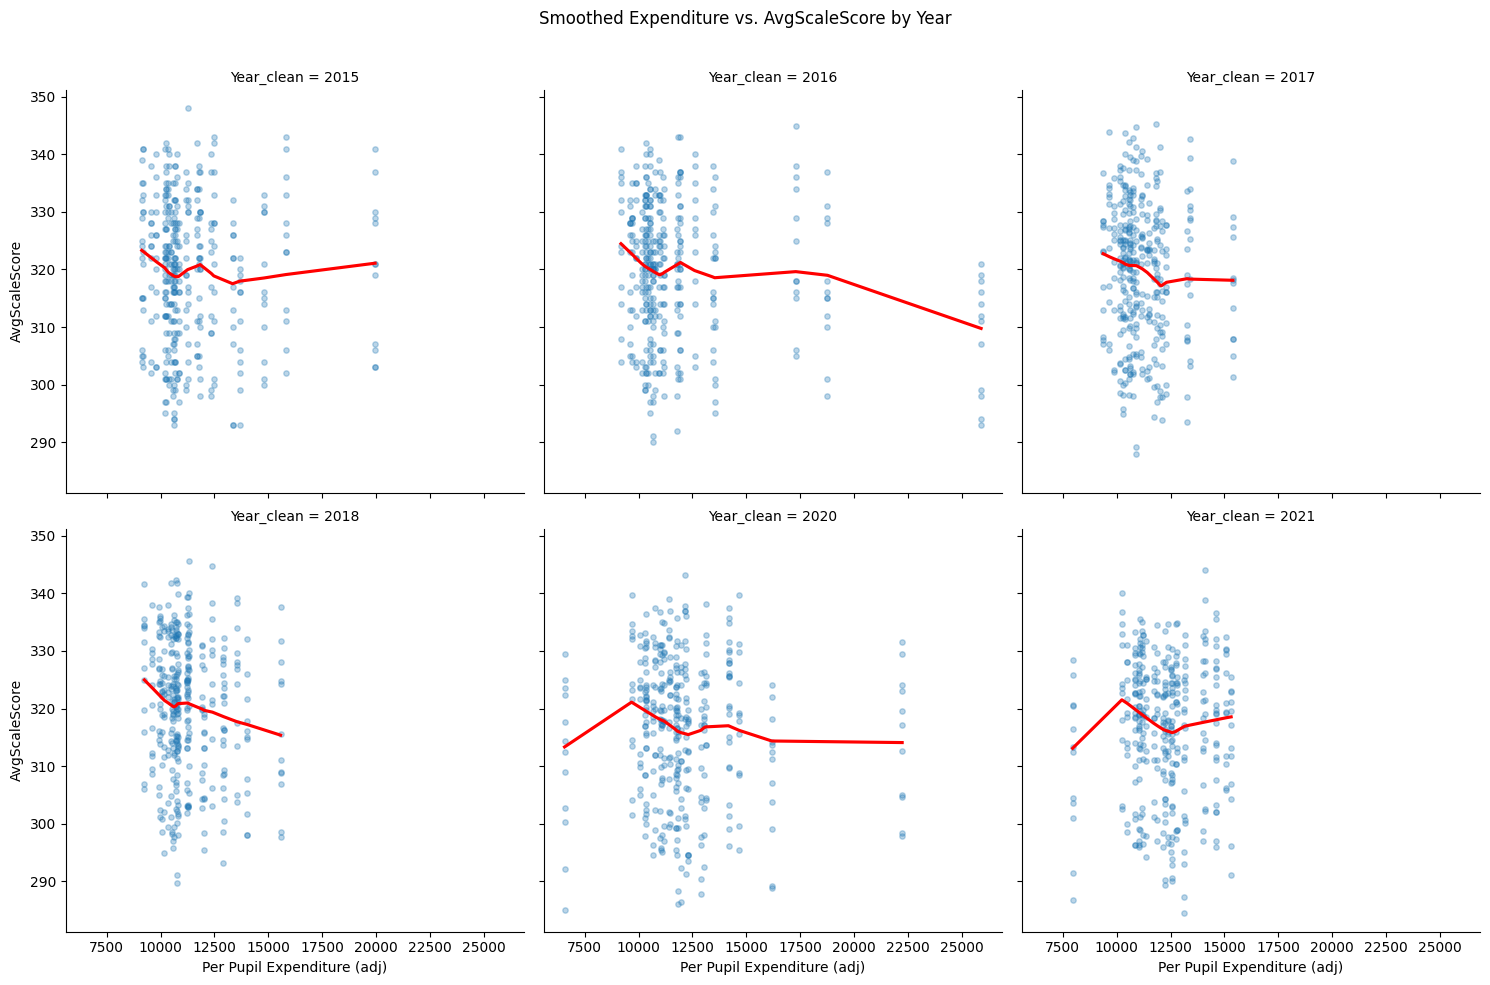

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out missing values
filtered_df = df[
    df["Per Pupil Expenditure (adj)"].notna() &
    df["AvgScaleScore"].notna() &
    df["Year_clean"].notna()
]

# Optional: restrict to years with enough data (e.g., >100 rows)
top_years = (
    filtered_df["Year_clean"]
    .value_counts()
    .loc[lambda s: s > 0]
    .index
)
filtered_df = filtered_df[filtered_df["Year_clean"].isin(top_years)]

# Plot smoothed relationship by year
g = sns.lmplot(
    x="Per Pupil Expenditure (adj)",
    y="AvgScaleScore",
    data=filtered_df,
    col="Year_clean",
    col_wrap=3,
    lowess=True,
    scatter_kws={'alpha': 0.3, 's': 15},
    line_kws={'color': 'red'}
)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Smoothed Expenditure vs. AvgScaleScore by Year")
plt.show()


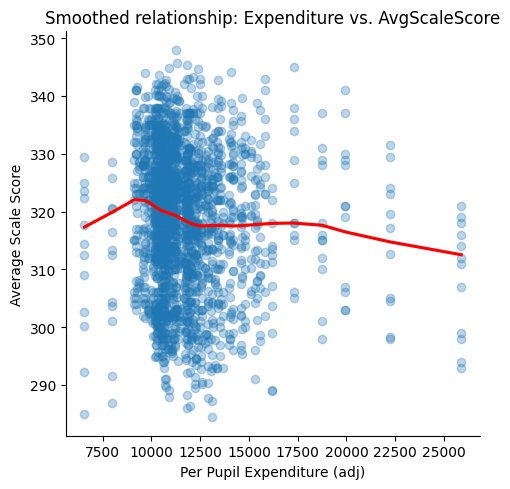

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    x="Per Pupil Expenditure (adj)", y="AvgScaleScore",
    data=df, lowess=True, scatter_kws={'alpha':0.3}, line_kws={'color':'red'}
)
plt.title("Smoothed relationship: Expenditure vs. AvgScaleScore")
plt.xlabel("Per Pupil Expenditure (adj)")
plt.ylabel("Average Scale Score")
plt.tight_layout()
plt.show()


try looking at matching one year time diff bettwen funding and scores.

Try and acount for ethnic groups in matching.

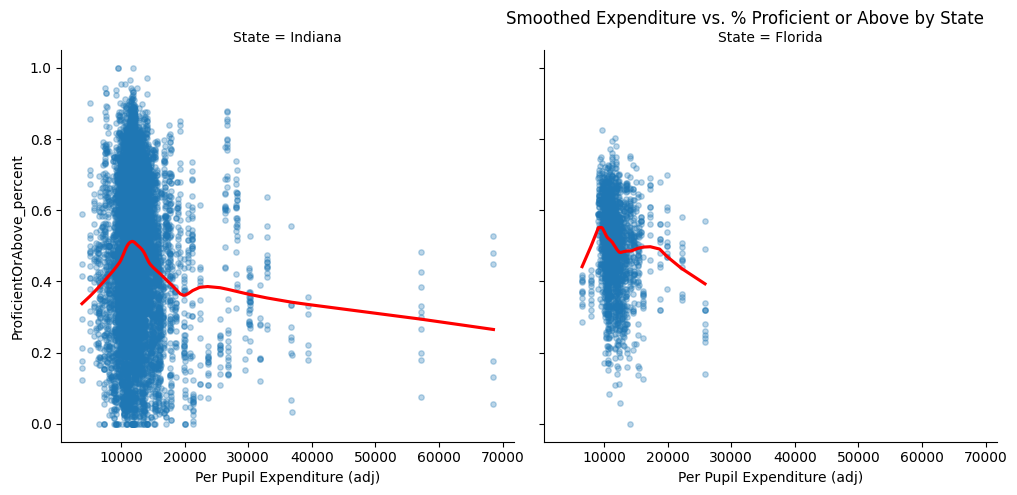

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out rows with missing values
filtered_df = df[
    df["Per Pupil Expenditure (adj)"].notna() &
    df["ProficientOrAbove_percent"].notna()
]

# Optionally include only states with enough data
top_states = (
    filtered_df["State"]
    .value_counts()
    .loc[lambda s: s > 100]  # Only states with >200 rows
    .index
)
filtered_df = filtered_df[filtered_df["State"].isin(top_states)]

# Plot the smoothed relationship
g = sns.lmplot(
    x="Per Pupil Expenditure (adj)",
    y="ProficientOrAbove_percent",
    data=filtered_df,
    col="State",
    col_wrap=3,  # Number of plots per row
    lowess=True,
    scatter_kws={'alpha': 0.3, 's': 15},
    line_kws={'color': 'red'}
)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Smoothed Expenditure vs. % Proficient or Above by State")
plt.show()

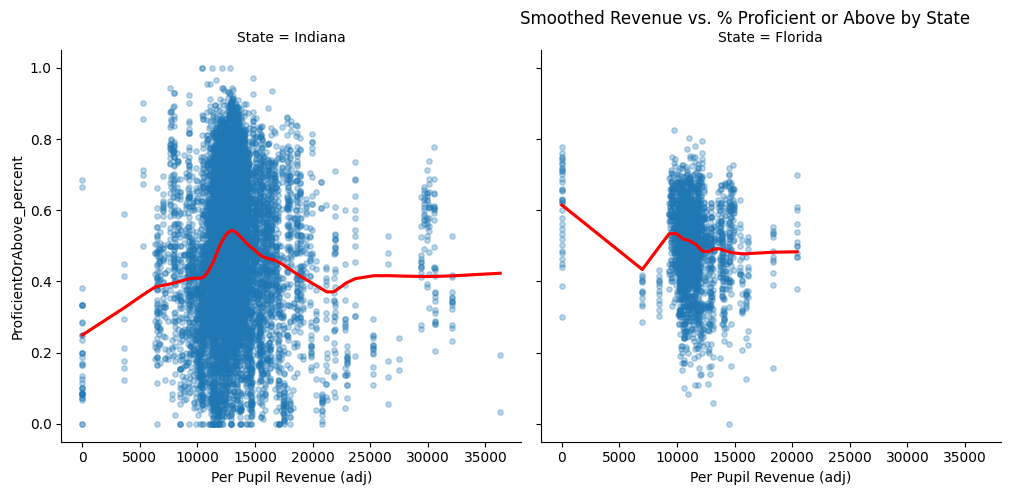

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out rows with missing values for revenue and proficiency
filtered_df = df[
    df["Per Pupil Revenue (adj)"].notna() &
    df["ProficientOrAbove_percent"].notna()
]

# Only include states with at least 100 rows
top_states = (
    filtered_df["State"]
    .value_counts()
    .loc[lambda s: s > 100]
    .index
)
filtered_df = filtered_df[filtered_df["State"].isin(top_states)]

# Smoothed scatter plots of revenue vs. proficiency by state
g = sns.lmplot(
    x="Per Pupil Revenue (adj)",
    y="ProficientOrAbove_percent",
    data=filtered_df,
    col="State",
    col_wrap=3,
    lowess=True,
    scatter_kws={'alpha': 0.3, 's': 15},
    line_kws={'color': 'red'}
)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Smoothed Revenue vs. % Proficient or Above by State")
plt.show()


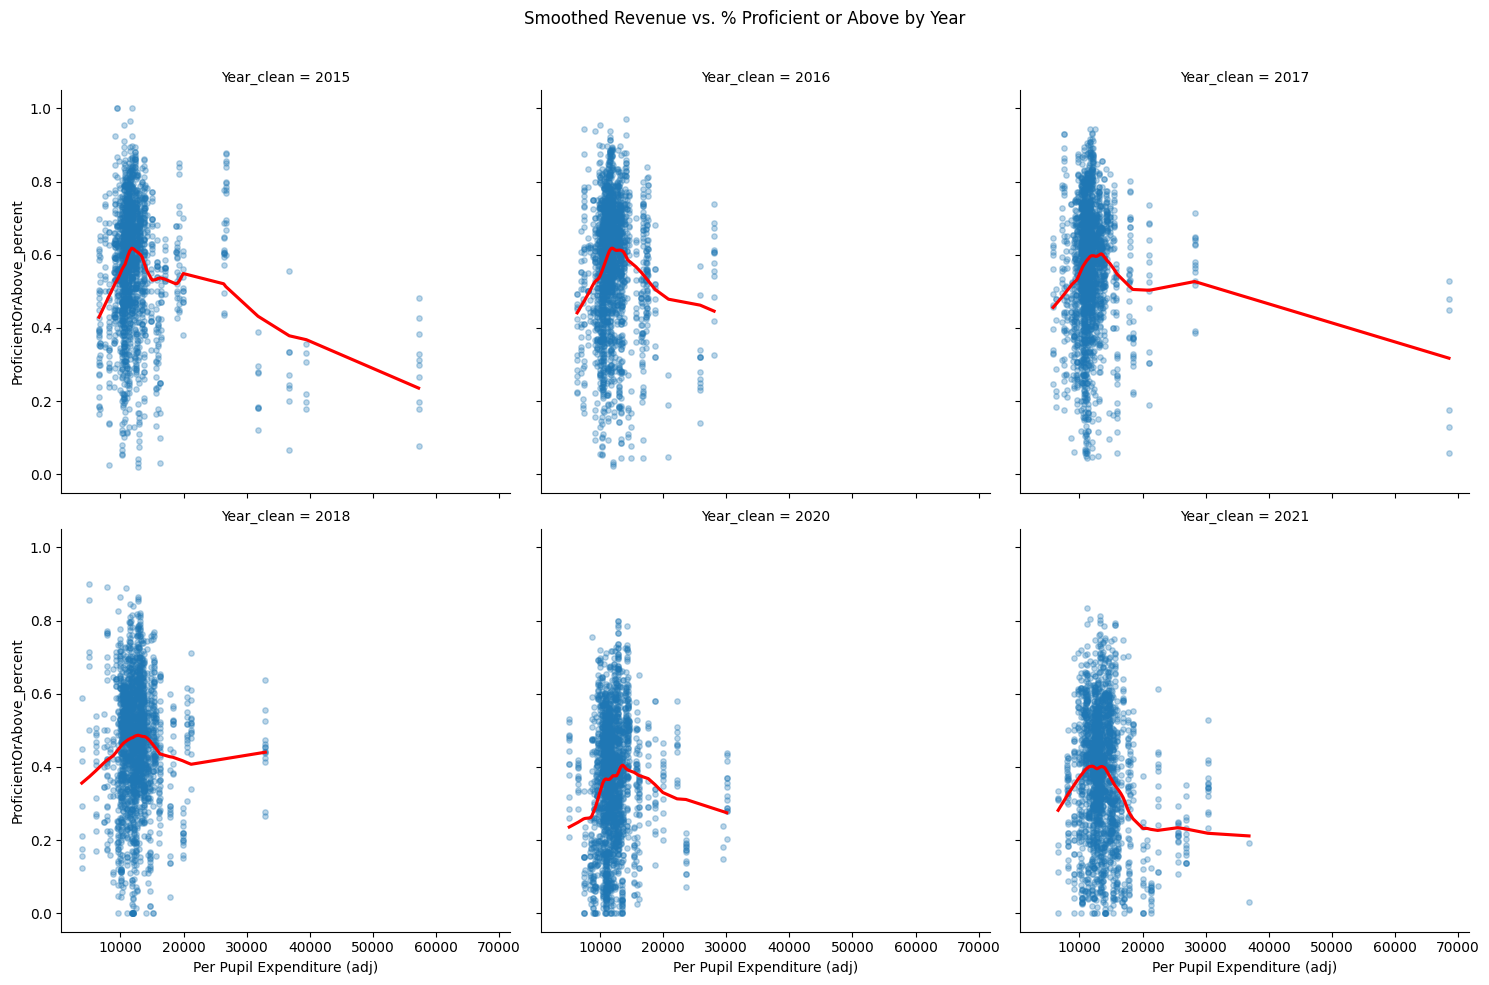

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter rows with valid revenue and proficiency
filtered_df = df[
    df["Per Pupil Expenditure (adj)"].notna() &
    df["ProficientOrAbove_percent"].notna() &
    df["Year_clean"].notna()
]

# Only include years with enough data (e.g., >100 rows)
top_years = (
    filtered_df["Year_clean"]
    .value_counts()
    .loc[lambda s: s > 100]
    .index
)
filtered_df = filtered_df[filtered_df["Year_clean"].isin(top_years)]

# Smoothed scatter plots of revenue vs. proficiency by year
g = sns.lmplot(
    x="Per Pupil Expenditure (adj)",
    y="ProficientOrAbove_percent",
    data=filtered_df,
    col="Year_clean",
    col_wrap=3,
    lowess=True,
    scatter_kws={'alpha': 0.3, 's': 15},
    line_kws={'color': 'red'}
)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Smoothed Revenue vs. % Proficient or Above by Year")
plt.show()
